# Observables from twopoppy

You need to **clone** (not download) the `twopoppy code`:

    git clone https://github.com/birnstiel/two-pop-py
    
Then go in the repository and install it e.g. with

    pip install -e .

All the imports and setup stuff:

In [ ]:
from planck_B_nu import planck_B_nu
import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as c
from astropy import units as u
from scipy.integrate import cumtrapz
import os, pandas as pd


#import twopoppy
#from twopoppy.wrapper import model_wrapper
#from twopoppy.args import args
from twopoppy import model

c_light = c.c.cgs.value
au = u.au.to('cm')
pc = u.pc.to('cm')
K =  u.Kelvin
M_sun = c.M_sun.cgs.value
year = u.year.to('s')
arcsec_sq = (u.arcsec**2).to(u.sr)  # arcsec**2 in steradian
R_sun        = 69550800000.0
%matplotlib inline
plt.style.use({'figure.dpi': 200})

In [ ]:
from importlib import reload
reload(model)

Get some data

In [ ]:
n_r       = 200
n_t       = 100
r_in      = 5*au
r_out     = 300*au
r         = np.logspace(np.log10(r_in),np.log10(r_out),n_r)
tstar     = 4010
rstar     = 1.806*R_sun
TT = ((0.05**0.25 * tstar * (r / rstar)**-0.5)**4 + (7.)**4)**0.25
Temp     = 200.*(r/au)**-0.5

In [ ]:
Temp

## Calculate optical depth and emission profiles

Define the function that reconstructs the size distribution

Now we call the function, passing our selected simulation, the time at which we want the results, and size/wavelength/opacity grids

In [ ]:
for ALPHA in [0.01, 0.005, 0.001, 0.0001]:
    for MD in [0.005, 0.025, 0.05, 0.1]:
        for rc in [20, 80, 140, 200]:
            for v_frag in [1000, 3000, 6000, 10000]:             
                
                r_c    = rc*au        # disk characteristic radius [cm]
                rho_s  = 1.2          # material density of in Drazkowska
                M_star = M_sun        # stellar mass [g]
                M_disk = MD*M_star  # gas disk mass [g]
                d2g    = 0.01         # dust-to-gas ratio [-]
                a_0    = 1e-5         # initial particle size [cm]
# snapshot time [s]

                time  = np.logspace(2,6,n_t)*year

# initial conditions: gas and dust surface densities [g cm^-2]

                sig_g = (r/r_c)**-1*np.exp(-(r/r_c))
                sig_g = sig_g/np.trapz(2*np.pi*r*sig_g,x=r)*M_disk
                sig_d = d2g*sig_g

# power-law temperature [K]

                #Temp     = 200.*(r/au)**-0.5

# alpha profile: a dip at 30*au - no scientific reason
                alpha = ALPHA*np.ones_like(r)
#alpha = 1e-2*np.ones_like(r)-9e-3*np.exp(-(r-30*au)**2/(2*(5*au)**2))

# v_gas is only for non-evolving gas disks, where you still
# want the dust to feel a gas velocity (e.g. a steady-state disk)
                v_gas = np.zeros_like(r)

                estick = 1.0
                opacity = np.load('opacity.npz') # load an npz file (array)
                k_a = opacity['k_a'] #len(k_a) = 1500
                k_s = opacity['k_s'] #len(k_s) = 1500
                lam = opacity['lam']  #all the three are contained in opacity.npz
                a_opac = opacity['a'] #len(a_opac) = 1500
                n_lam = len(lam)
                
                res = model.run(r, a_0, time, sig_g, sig_d, v_gas, Temp, alpha, M_star, v_frag, rho_s, 1)

                t     = res[0]
                sig_d = res[1]
                sig_g = res[2]
                v_bar = res[3]
                v_gas = res[4]
                v_0   = res[5]
                v_1   = res[6]
                a_dr  = res[7]
                a_fr  = res[8]
                a_df  = res[9]
                a_t   = res[10]
                
                a = np.logspace(np.log10(a_0), np.log10(5 * a_t.max()), 150) 
                from twopoppy.distribution_reconstruction import reconstruct_size_distribution as rsd
                def get_distri( it, r, a, time, sig_g, sig_d, alpha, rho_s, Temp, M_star, v_frag, a0=a_0):
    
                    if Temp.ndim == 1:
                        T = Temp
                    else:
                        T = Temp[it]
    
                    distri = rsd(
                        r, 
                        a, 
                        time[it],
                        sig_g[it],
                        sig_d[it], 
                        alpha, 
                        rho_s, 
                        T, 
                        M_star, 
                        v_frag,
                        a_0 = 1e-5) 
                    return distri[:2]

        
                def get_results(r, t, a, Temp, sample_time, it, lam, a_opac, k_a, distance=140 * pc, flux_fraction=0.68):
    

    # interpolate opacity on the same particle size grid as the size distribution
   
                    kappa = np.array([10.**np.interp(np.log10(a), np.log10(a_opac), np.log10(k)) for k in k_a.T]).T  #interpolates the opacity
    
                    it = np.abs(t - sample_time).argmin()
    
                    if Temp.ndim == 1:
                        T = Temp
                    else:
                        T = Temp[it]
        
    # reconstruct the size distribution
        
                    sig_da, a_max = get_distri(2, r, a, time, sig_g, sig_d, alpha, rho_s, T, M_star, v_frag,a_0)
    
    # calculate planck function at every wavelength and radius

                    Bnu = planck_B_nu(c_light / (np.array(lam[2], ndmin=2).T), np.array(T, ndmin=2))  # shape = (n_lam, n_r)

    # calculate optical depth

                    tau = (kappa.T[:, :, np.newaxis] * sig_da[np.newaxis, :, :])  # shape = (n_l, n_a, n_r)
                    tau = tau.sum(1)  # shape = (n_l, n_r)

    # calculate intensity at every wavelength and radius for this snapshot
    # here the intensity is still in plain CGS units (per sterad)

                    intens = Bnu * (1 - np.exp(-tau))

    # calculate the fluxes
    
                    flux = distance**-2 * cumtrapz(2 * np.pi * r * intens, x=r, axis=1, initial=0)
    
                    flux_t = flux[:, -1] / 1e-23  # store the integrated flux density in Jy (sanity check: TW Hya @ 870 micron and 54 parsec is about 1.5 Jy)

    # converted intensity to Jy/arcsec**2

                    Inu = intens * arcsec_sq / 1e-23
    
#   interpolate radius whithin which >=68% of the dust mass is  # Effective radius (see Tripani)
    
                    rf = np.array([np.interp(flux_fraction, _f / _f[-1], r) for _f in flux])
    
                    path = '/home/apo/Codes/two-pop-py/results_088.csv'
    
                    import pandas as pd
        
                    data_dict = {'mdisk': [M_disk/M_sun], 'alpha' : [alpha[0]], 'r_c [AU]' : [r_c/au], 'v_frag' : [v_frag], 'reff [AU]' : [rf[2]/au], 'fluxmm' : [flux_t[2]]}
                    df = pd.DataFrame(data=data_dict)
                    column_order = [ 'mdisk', 'alpha', 'r_c [AU]', 'v_frag', 'reff [AU]', 'fluxmm']
                    df = df[column_order]

    #df = df.append(data_dict, ignore_index=True)
                    with open('/home/apo/Codes/two-pop-py/results_088.csv', 'a') as f:
                        df.to_csv(f, header=False)
     
                    return rf[2], flux_t[2], tau, Inu, sig_da, a_max
        

                
                sample_time = t.searchsorted(1e6 * year)  #check searchsorted
                IT  = -1
                rf, flux_t, tau, Inu, sig_da, a_max = get_results(r, t, a, Temp, sample_time, IT, lam, a_opac, k_a)
                

Plot the reconstructed size distribution

In [58]:
df = pd.read_csv('/home/apo/Codes/two-pop-py/results_088.csv')
df

,Unnamed: 0,Mdisk,alpha,r_c,v_frag,Reff,Fmm
0,0,0.005,0.0100,20,1000,21.431668,0.173905
1,0,0.005,0.0100,20,3000,21.451566,0.174579
2,0,0.005,0.0100,20,6000,21.455847,0.175174
3,0,0.005,0.0100,20,10000,21.447912,0.175374
4,0,0.005,0.0100,80,1000,45.031602,0.118269
5,0,0.005,0.0100,80,3000,45.446701,0.119243
6,0,0.005,0.0100,80,6000,45.656810,0.119904
7,0,0.005,0.0100,80,10000,45.829347,0.120412
8,0,0.005,0.0100,140,1000,62.354053,0.097060
9,0,0.005,0.0100,140,3000,62.860709,0.098048


In [ ]:
df_Md  =  df.loc[:,'Mdisk']
df_rf  =  df.loc[:,'Reff']
df_Fmm =  df["Fmm"].values

In [57]:
df_01M     =  df.loc[df['Mdisk'] == 0.1]
df_005M    =  df.loc[df['Mdisk'] == 0.05]
df_0025M   =  df.loc[df['Mdisk'] == 0.025]
df_0005M   =  df.loc[df['Mdisk'] == 0.005]

df_001a    =  df.loc[df['alpha'] == 0.01]
df_0005a   =  df.loc[df['alpha'] == 0.005]
df_0001a   =  df.loc[df['alpha'] == 0.001]
df_00001a  =  df.loc[df['alpha'] == 0.0001]

df_20r     =  df.loc[df['r_c']  == 20]
df_80r     =  df.loc[df['r_c']  == 80]
df_140r    =  df.loc[df['r_c']  == 140]
df_200r    =  df.loc[df['r_c']  == 200]

df_1000v   =  df.loc[df['v_frag']  == 1000]
df_3000v   =  df.loc[df['v_frag']  == 3000]
df_6000v   =  df.loc[df['v_frag']  == 6000]
df_10000v  =  df.loc[df['v_frag']  == 10000]


Fmmall     =  df['Fmm'].values
Reffall    =  df['Reff'].values
Reff01     =  df_01M['Reff'].values
Reff005    =  df_005M['Reff'].values
Reff0025   =  df_0025M['Reff'].values
Reff0005   =  df_0005M['Reff'].values

Fmm01      =  df_01M['Fmm'].values
Fmm005     =  df_005M['Fmm'].values
Fmm0025    =  df_0025M['Fmm'].values
Fmm0005    =  df_0005M['Fmm'].values

Reff001a   =  df_001a['Reff'].values
Reff0005a  =  df_0005a['Reff'].values
Reff0001a  =  df_0001a['Reff'].values
Reff00001a =  df_00001a['Reff'].values

Fmm001a    =  df_001a['Fmm'].values
Fmm0005a   =  df_0005a['Fmm'].values
Fmm0001a   =  df_0001a['Fmm'].values
Fmm00001a  =  df_00001a['Fmm'].values


## Plot the opacity

In [ ]:
opacity = np.load('opacity.npz') # load an npz file (array)
k_a = opacity['k_a'] #len(k_a) = 1500
k_s = opacity['k_s'] #len(k_s) = 1500
lam = opacity['lam']  #all the three are contained in opacity.npz
a_opac = opacity['a'] #len(a_opac) = 1500
n_lam = len(lam)

In [ ]:
f, ax = plt.subplots()
#for ilam in range(n_lam):
ax.loglog(a_opac, k_a[:, 2], label='$\lambda = {:.3g}$ mm'.format(10 * lam[2]))
ax.legend()
ax.set_xlabel('particle size [cm]')
ax.set_ylabel('$\kappa_\mathrm{abs}$ [cm$^2$/g]');

In [ ]:
f, ax = plt.subplots()
for ilam in range(n_lam):
    ax.loglog(a_opac, k_a[:, ilam], label='$\lambda = {:.3g}$ mm'.format(10 * lam[ilam]))
ax.legend()
ax.set_xlabel('particle size [cm]')
ax.set_ylabel('$\kappa_\mathrm{abs}$ [cm$^2$/g]');

## Plot the emission profiles

## Plot the spectral dependence of $r_\mathrm{eff}$ and the flux

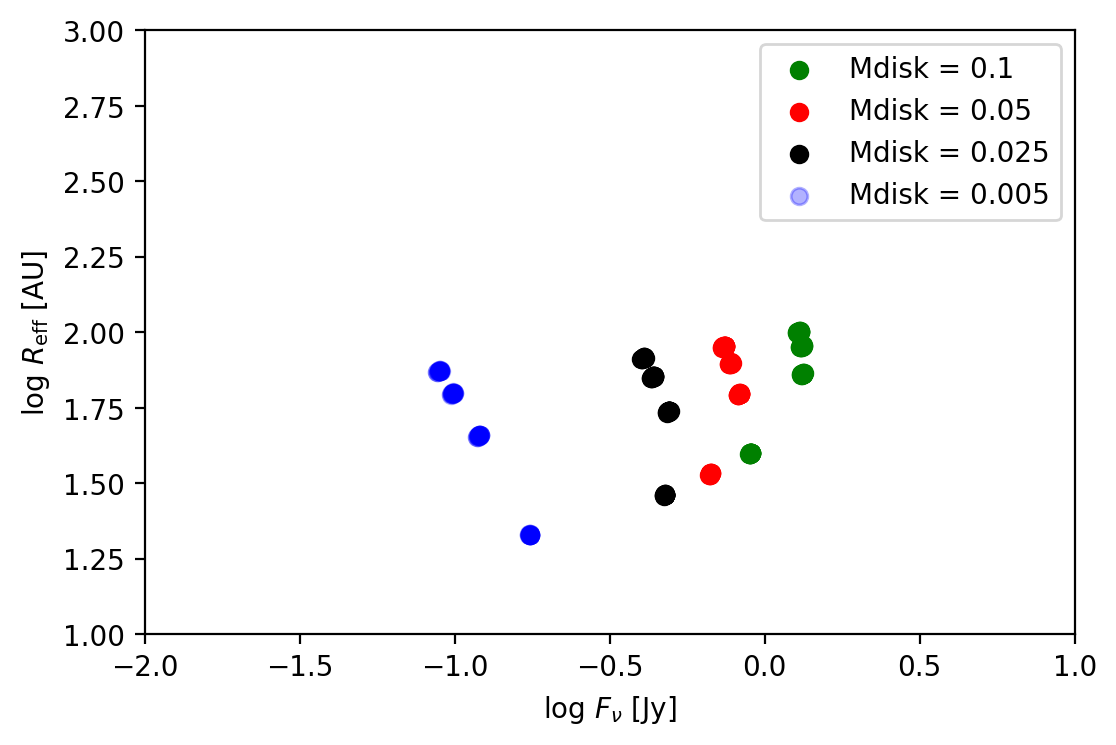

In [61]:
f, ax = plt.subplots()
ax.scatter(np.log10(Fmm01),np.log10(Reff01), c = 'g', label='Mdisk = 0.1')
ax.set_xlim(-3, 1.5)
ax.set_ylim(2, 5)
ax.set_xlabel(r'log $F_\nu$ [Jy]')
ax.set_ylabel(r'log $R_\mathrm{eff}$ [au]')


ax.scatter(np.log10(Fmm005),np.log10(Reff005), c = 'r',label='Mdisk = 0.05')
ax.set_xlim(-3, 1.5)
ax.set_ylim(2, 5)
ax.set_xlabel(r'log $F_\nu$ [Jy]')
ax.set_ylabel(r'log $R_\mathrm{eff}$ [au]')

ax.scatter(np.log10(Fmm0025),np.log10(Reff0025), c = 'k', label='Mdisk = 0.025')
ax.set_xlim(-3, 1.5)
ax.set_ylim(2, 5)
ax.set_xlabel(r'log $F_\nu$ [Jy]')
ax.set_ylabel(r'log $R_\mathrm{eff}$ [au]')


ax.scatter(np.log10(Fmm0005),np.log10(Reff0005), c = 'b',label='Mdisk = 0.005', alpha=0.3)
ax.set_xlim(-2, 1)
ax.set_ylim(1, 3)
ax.set_xlabel(r'log $F_\nu$ [Jy]')
ax.set_ylabel(r'log $R_\mathrm{eff}$ [AU]')


ax.legend();
#ax.set_title('(Md,Rc,alpha,vfrag) = {:.4g}M*, {:.4g}AU, {:.4g} , {:.4g}cm/s'.format(M_disk / M_star, r_c / au, alpha[0], v_frag ))
#f.savefig('fig1.pdf')

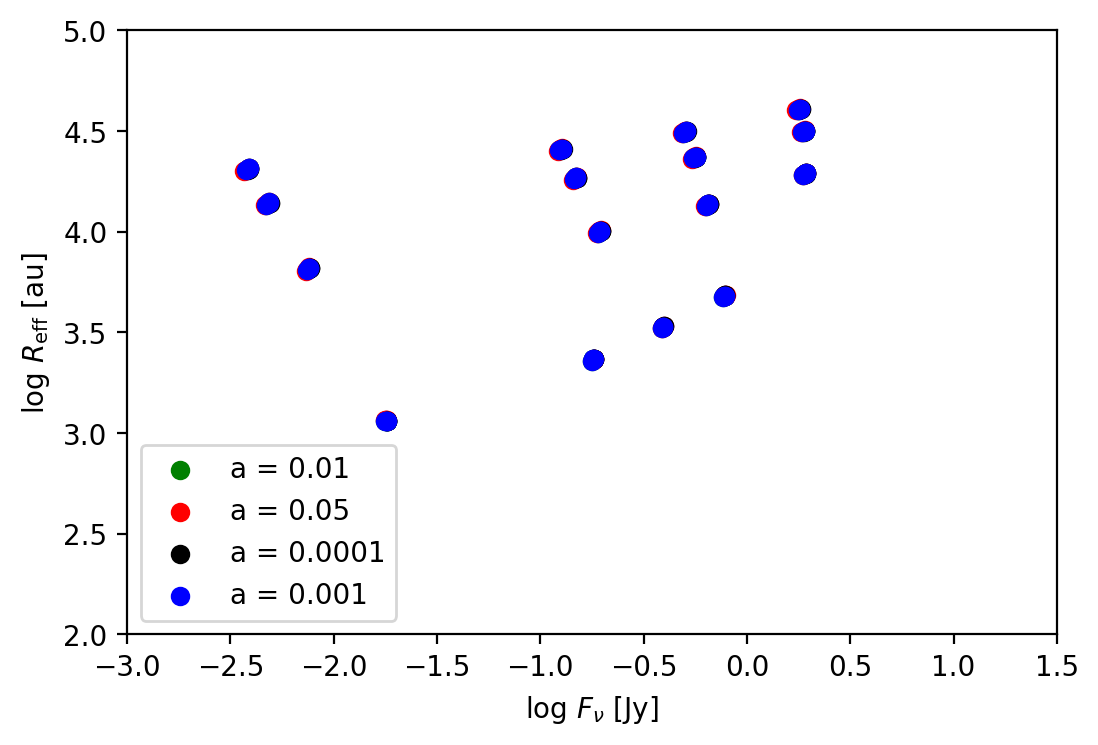

In [48]:
f, ax = plt.subplots()
ax.scatter(np.log(Fmm0001a),np.log(Reff0001a), c = 'g', label='a = 0.01')
ax.set_xlim(-3, 1.5)
ax.set_ylim(2, 5)
ax.set_xlabel(r'log $F_\nu$ [Jy]')
ax.set_ylabel(r'log $R_\mathrm{eff}$ [au]')


ax.scatter(np.log(Fmm0005a),np.log(Reff0005a), c = 'r',label='a = 0.05' )
ax.set_xlim(-3, 1.5)
ax.set_ylim(2, 5)
ax.set_xlabel(r'log $F_\nu$ [Jy]')
ax.set_ylabel(r'log $R_\mathrm{eff}$ [au]')

ax.scatter(np.log(Fmm00001a),np.log(Reff00001a), c = 'k', label='a = 0.0001')
ax.set_xlim(-3, 1.5)
ax.set_ylim(2, 5)
ax.set_xlabel(r'log $F_\nu$ [Jy]')
ax.set_ylabel(r'log $R_\mathrm{eff}$ [au]')


ax.scatter(np.log(Fmm0001a),np.log(Reff0001a), c = 'b',label='a = 0.001')
ax.set_xlim(-3, 1.5)
ax.set_ylim(2, 5)
ax.set_xlabel(r'log $F_\nu$ [Jy]')
ax.set_ylabel(r'log $R_\mathrm{eff}$ [au]')


ax.legend();